# 09 - Feature Selection & Engineering Optimization

This notebook optimizes features to break below 9% MAPE (currently at 9.44% with Ensemble).

## Approach
1. Analyze feature importance using XGBoost
2. Add new engineered features (time-based, interaction, advanced lags)
3. Remove bottom 20% low-importance features
4. Retrain ensemble with optimized feature set

## Target
- Current best: 9.44% MAPE (Ensemble)
- Goal: < 9.00% MAPE

In [1]:
import sys
import json
import warnings
from pathlib import Path
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# Import models and evaluation
from volume_forecast.evaluation import WalkForwardValidator, ModelBenchmark
from volume_forecast.models import (
    XGBoostModel, LightGBMModel, ProphetModel, EnsembleModel
)
from volume_forecast.features import FeaturePipeline

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')

print("Setup complete!")

Setup complete!


In [2]:
# Load data
data_path = project_root / "data" / "raw" / "synthetic_volumes.csv"
df = pd.read_csv(data_path, parse_dates=["date"])
df = df.sort_values('date').reset_index(drop=True)

# Apply feature pipeline
pipeline = FeaturePipeline(
    date_column='date',
    target_columns=['daily_logins'],
    include_events=True,
    include_football=True,
)
df_features = pipeline.fit_transform(df)

TARGET = 'daily_logins'
FEATURE_COLUMNS = pipeline.get_feature_names()

print(f"Dataset shape: {df_features.shape}")
print(f"Features: {len(FEATURE_COLUMNS)}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")

Dataset shape: (731, 50)
Features: 46
Date range: 2023-01-01 to 2024-12-31


## 1. Baseline Feature Importance Analysis

Train XGBoost with current features to establish importance baseline.

In [3]:
# Define external features (same as notebook 07)
EXTERNAL_FEATURES = [
    'day_of_week', 'is_weekend', 'day_of_week_sin', 'day_of_week_cos',
    'month', 'month_sin', 'month_cos',
    'daily_logins_rolling_mean_7', 'daily_logins_rolling_mean_14', 'daily_logins_rolling_mean_30',
    'daily_logins_rolling_std_7', 'daily_logins_rolling_std_14', 'daily_logins_rolling_std_30',
    'is_bank_holiday', 'is_racing_event', 'is_tennis_event',
    'is_boxing_event', 'is_football_match', 'event_importance',
    'any_event_tomorrow', 'any_event_in_2_days', 'any_event_in_3_days',
    'bank_holiday_tomorrow', 'bank_holiday_in_2_days', 'bank_holiday_in_3_days',
    'football_tomorrow', 'football_in_2_days', 'football_in_3_days',
    'any_event_yesterday', 'any_event_2_days_ago',
    'bank_holiday_yesterday', 'bank_holiday_2_days_ago',
    'football_yesterday', 'football_2_days_ago',
]

# Train XGBoost with best params to get feature importance
xgb_model = XGBoostModel(
    n_estimators=88,
    max_depth=3,
    learning_rate=0.1105,
    min_child_weight=8,
    lags=[1, 7, 14],
    external_features=EXTERNAL_FEATURES,
    name='XGBoost_Baseline'
)

# Use first 365 days for training
train_df = df_features.iloc[:365].copy()
xgb_model.fit(train_df, TARGET)

print("XGBoost trained for feature importance analysis")

XGBoost trained for feature importance analysis


In [4]:
# Extract feature importances
feature_names = xgb_model._feature_columns
importances = xgb_model._model.feature_importances_

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Calculate percentile threshold (bottom 20%)
threshold_20 = importance_df['importance'].quantile(0.20)
importance_df['keep'] = importance_df['importance'] >= threshold_20

print(f"Total features: {len(importance_df)}")
print(f"20th percentile threshold: {threshold_20:.6f}")
print(f"Features to keep: {importance_df['keep'].sum()}")
print(f"Features to remove: {(~importance_df['keep']).sum()}")

# Show top 20 features
print("\nTop 20 Features:")
importance_df.head(20)

Total features: 37
20th percentile threshold: 0.000000
Features to keep: 37
Features to remove: 0

Top 20 Features:


,feature,importance,keep
21,event_importance,0.3394,True
3,day_of_week,0.1949,True
5,day_of_week_sin,0.0721,True
16,is_bank_holiday,0.0680,True
13,daily_logins_rolling_std_7,0.0472,True
9,month_cos,0.0389,True
14,daily_logins_rolling_std_14,0.0350,True
1,lag_7,0.0343,True
10,daily_logins_rolling_mean_7,0.0292,True
0,lag_1,0.0203,True


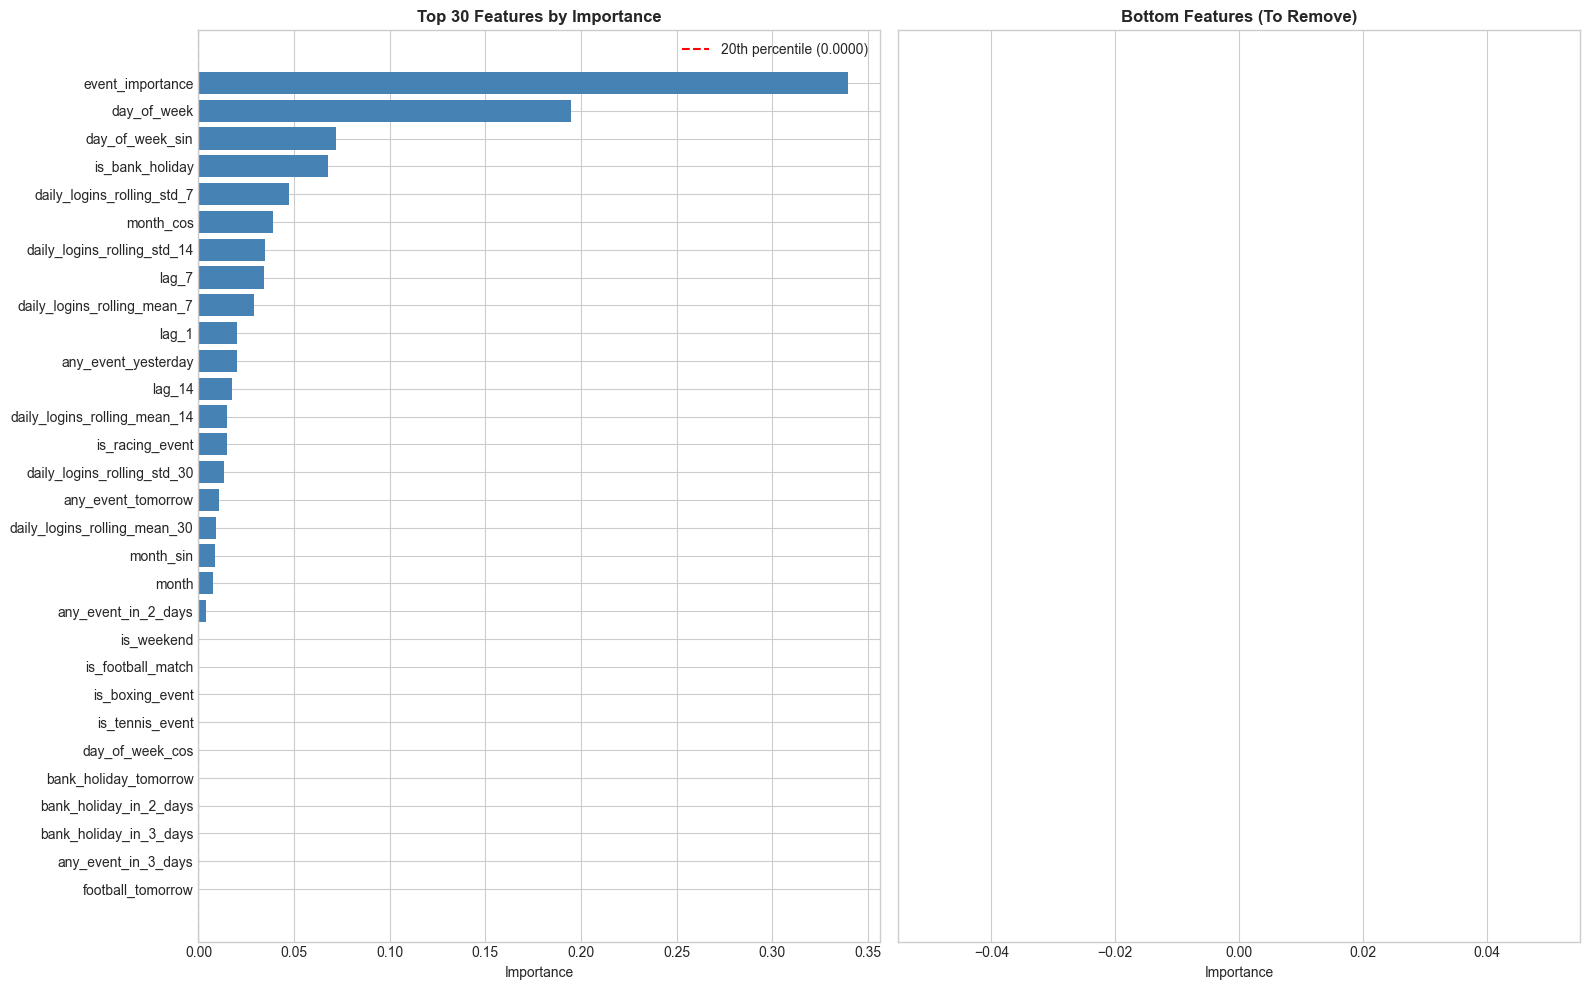


Features to REMOVE (bottom 20%):


In [5]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Left: Top 30 features
ax1 = axes[0]
top_30 = importance_df.head(30)
colors = ['steelblue' if k else 'lightcoral' for k in top_30['keep']]
ax1.barh(range(len(top_30)), top_30['importance'], color=colors)
ax1.set_yticks(range(len(top_30)))
ax1.set_yticklabels(top_30['feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Importance')
ax1.set_title('Top 30 Features by Importance', fontweight='bold')
ax1.axvline(x=threshold_20, color='red', linestyle='--', label=f'20th percentile ({threshold_20:.4f})')
ax1.legend()

# Right: Bottom features (to be removed)
ax2 = axes[1]
bottom = importance_df[~importance_df['keep']]
ax2.barh(range(len(bottom)), bottom['importance'], color='lightcoral')
ax2.set_yticks(range(len(bottom)))
ax2.set_yticklabels(bottom['feature'])
ax2.invert_yaxis()
ax2.set_xlabel('Importance')
ax2.set_title('Bottom Features (To Remove)', fontweight='bold')

plt.tight_layout()
plt.show()

# List features to remove
print("\nFeatures to REMOVE (bottom 20%):")
for f in importance_df[~importance_df['keep']]['feature'].tolist():
    print(f"  - {f}")

## 2. New Feature Engineering

Adding 14 new features in 3 categories:
- **Time-based (4):** week_of_month, days_to_month_end, days_from_month_start, quarter
- **Interaction (4):** weekend_event, payday_weekend, month_end_rolling, high_importance_weekend
- **Advanced lags (6):** lag_2, lag_3, lag_28, lag_diff_7, lag_diff_28, lag_ratio_7

In [6]:
def add_new_features(df: pd.DataFrame, target: str = 'daily_logins') -> pd.DataFrame:
    """Add new engineered features to dataframe."""
    df = df.copy()
    dates = pd.to_datetime(df['date'])

    # === TIME-BASED FEATURES ===
    # Week of month (1-5)
    df['week_of_month'] = ((dates.dt.day - 1) // 7) + 1

    # Days to/from month boundaries
    df['days_to_month_end'] = dates.dt.daysinmonth - dates.dt.day
    df['days_from_month_start'] = dates.dt.day - 1

    # Quarter
    df['quarter'] = dates.dt.quarter

    # === INTERACTION FEATURES ===
    # Weekend + any event
    has_event = (df['event_count'] > 0).astype(int) if 'event_count' in df.columns else 0
    df['weekend_event'] = df['is_weekend'] * has_event

    # Payday proximity + weekend
    df['payday_weekend'] = ((df['days_to_payday'] <= 2) & (df['is_weekend'] == 1)).astype(int)

    # Month end + rolling mean
    df['month_end_rolling'] = df['is_month_end'] * df.get(f'{target}_rolling_mean_7', 0)

    # High importance event + weekend
    high_importance = (df['event_importance'] >= 3).astype(int) if 'event_importance' in df.columns else 0
    df['high_importance_weekend'] = high_importance * df['is_weekend']

    # === ADVANCED LAG FEATURES ===
    # Short-term lags
    df[f'{target}_lag_2'] = df[target].shift(2)
    df[f'{target}_lag_3'] = df[target].shift(3)

    # Monthly lag (4 weeks)
    df[f'{target}_lag_28'] = df[target].shift(28)

    # Lag differences (momentum)
    if f'{target}_lag_7' in df.columns:
        df[f'{target}_lag_diff_7'] = df[target] - df[f'{target}_lag_7']
    else:
        df[f'{target}_lag_diff_7'] = df[target] - df[target].shift(7)

    df[f'{target}_lag_diff_28'] = df[target] - df[f'{target}_lag_28']

    # Lag ratio (relative change)
    lag_7 = df[f'{target}_lag_7'] if f'{target}_lag_7' in df.columns else df[target].shift(7)
    df[f'{target}_lag_ratio_7'] = df[target] / lag_7.replace(0, np.nan)

    return df

# Apply new features
df_enhanced = add_new_features(df_features, TARGET)

# List new features
NEW_FEATURES = [
    'week_of_month', 'days_to_month_end', 'days_from_month_start', 'quarter',
    'weekend_event', 'payday_weekend', 'month_end_rolling', 'high_importance_weekend',
    f'{TARGET}_lag_2', f'{TARGET}_lag_3', f'{TARGET}_lag_28',
    f'{TARGET}_lag_diff_7', f'{TARGET}_lag_diff_28', f'{TARGET}_lag_ratio_7'
]

print(f"Added {len(NEW_FEATURES)} new features:")
for f in NEW_FEATURES:
    print(f"  + {f}")
print(f"\nDataset shape: {df_features.shape} -> {df_enhanced.shape}")

Added 14 new features:
  + week_of_month
  + days_to_month_end
  + days_from_month_start
  + quarter
  + weekend_event
  + payday_weekend
  + month_end_rolling
  + high_importance_weekend
  + daily_logins_lag_2
  + daily_logins_lag_3
  + daily_logins_lag_28
  + daily_logins_lag_diff_7
  + daily_logins_lag_diff_28
  + daily_logins_lag_ratio_7

Dataset shape: (731, 50) -> (731, 64)


## 3. Feature Selection

Combine new features with existing high-importance features, removing bottom 20%.

In [7]:
# Get features to keep from baseline analysis
features_to_keep = importance_df[importance_df['keep']]['feature'].tolist()
features_to_remove = importance_df[~importance_df['keep']]['feature'].tolist()

# Build optimized external features list
# Start with features that were kept
optimized_external = [f for f in EXTERNAL_FEATURES if f in features_to_keep or f not in importance_df['feature'].tolist()]

# Add new features (except target lags which are handled internally)
new_external = [f for f in NEW_FEATURES if not f.startswith(f'{TARGET}_lag')]
optimized_external.extend(new_external)

# New lag features for model
NEW_LAGS = [2, 3, 28]  # Additional lags beyond [1, 7, 14]
OPTIMIZED_LAGS = [1, 2, 3, 7, 14, 28]

print(f"Original external features: {len(EXTERNAL_FEATURES)}")
print(f"Features removed (low importance): {len(features_to_remove)}")
print(f"New features added: {len(new_external)}")
print(f"Optimized external features: {len(optimized_external)}")
print(f"\nOptimized lags: {OPTIMIZED_LAGS}")

# Save optimized feature list
optimized_features_path = project_root / "data" / "processed" / "selected_features.json"
with open(optimized_features_path, 'w') as f:
    json.dump({
        'external_features': optimized_external,
        'lags': OPTIMIZED_LAGS,
        'removed_features': features_to_remove,
        'new_features': NEW_FEATURES
    }, f, indent=2)
print(f"\nSaved to: {optimized_features_path}")

Original external features: 34
Features removed (low importance): 0
New features added: 8
Optimized external features: 42

Optimized lags: [1, 2, 3, 7, 14, 28]

Saved to: C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\selected_features.json


In [8]:
# Train XGBoost with ALL features (original + new) to re-analyze importance
ALL_EXTERNAL = EXTERNAL_FEATURES + new_external

xgb_full = XGBoostModel(
    n_estimators=88,
    max_depth=3,
    learning_rate=0.1105,
    min_child_weight=8,
    lags=OPTIMIZED_LAGS,
    external_features=ALL_EXTERNAL,
    name='XGBoost_Full'
)

# Train on first 365 days
train_enhanced = df_enhanced.iloc[:365].copy()
xgb_full.fit(train_enhanced, TARGET)

# Get new importance ranking
full_feature_names = xgb_full._feature_columns
full_importances = xgb_full._model.feature_importances_

full_importance_df = pd.DataFrame({
    'feature': full_feature_names,
    'importance': full_importances
}).sort_values('importance', ascending=False)

# Mark new features
full_importance_df['is_new'] = full_importance_df['feature'].apply(
    lambda x: x in NEW_FEATURES or any(x.endswith(f'_lag_{l}') for l in NEW_LAGS)
)

print("Feature Importance with New Features:")
print(f"Total features: {len(full_importance_df)}")
print(f"\nNew features in top 20:")
top_20_new = full_importance_df.head(20)[full_importance_df.head(20)['is_new']]
for _, row in top_20_new.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

Feature Importance with New Features:
Total features: 48

New features in top 20:
  days_to_month_end: 0.0191


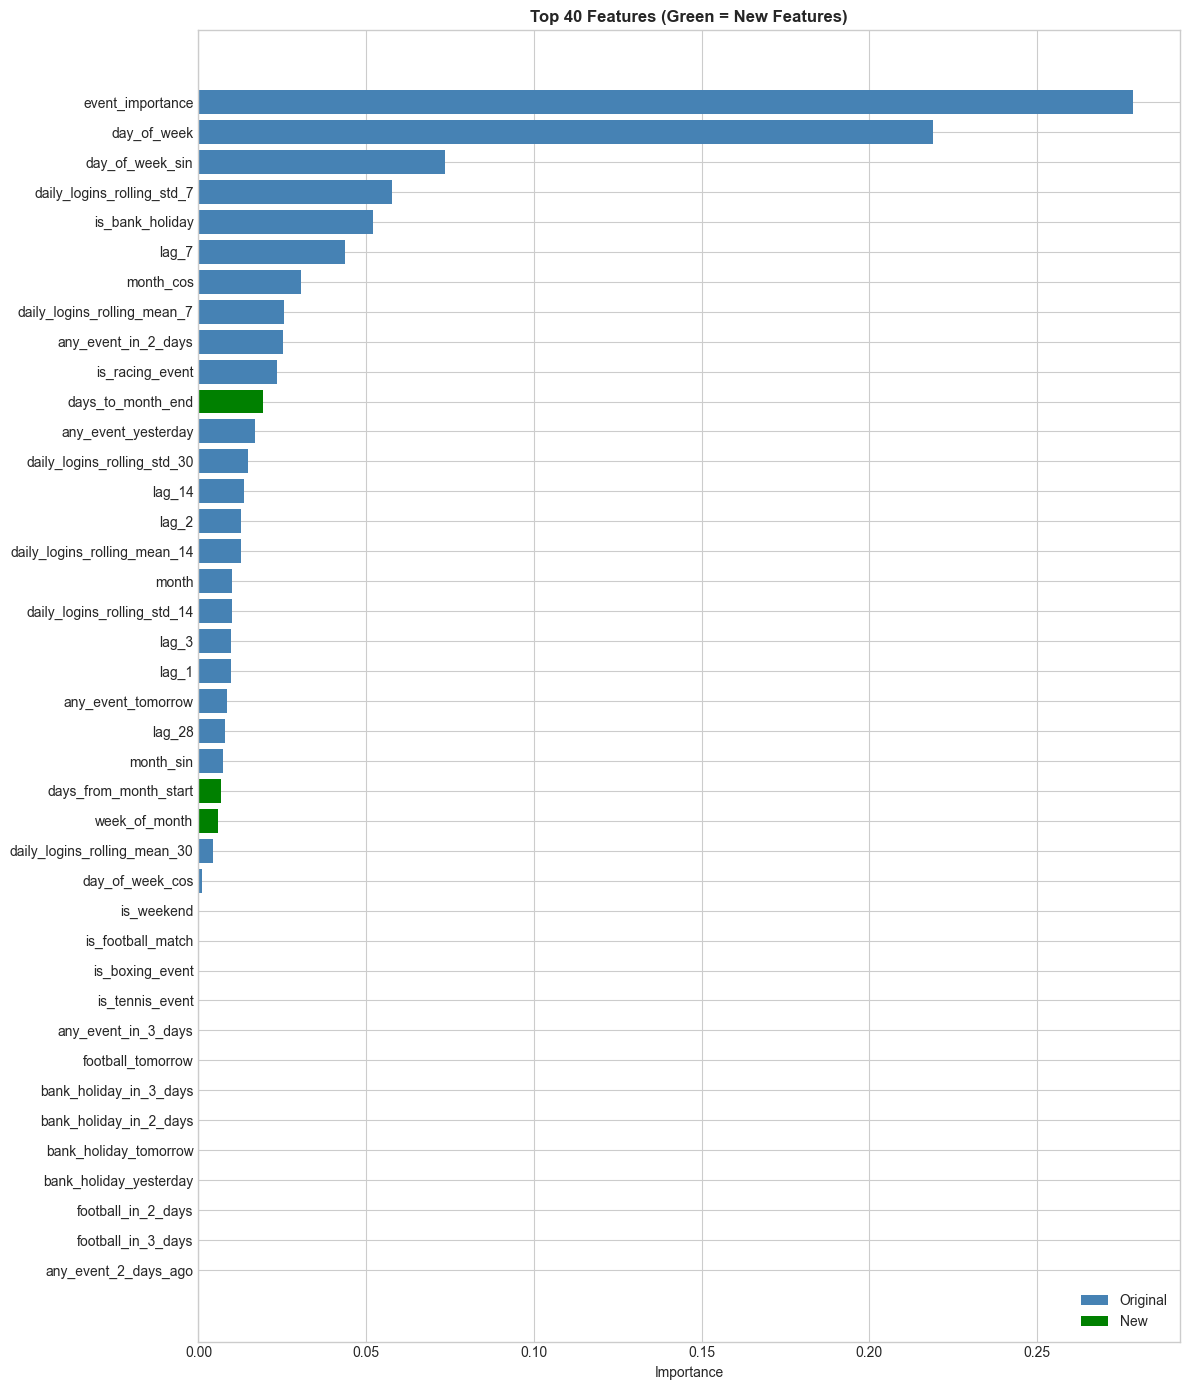

Saved importance ranking to: C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\feature_importance.csv


In [9]:
# Visualize new importance ranking
fig, ax = plt.subplots(figsize=(12, 14))

top_40 = full_importance_df.head(40)
colors = ['green' if is_new else 'steelblue' for is_new in top_40['is_new']]

ax.barh(range(len(top_40)), top_40['importance'], color=colors)
ax.set_yticks(range(len(top_40)))
ax.set_yticklabels(top_40['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Top 40 Features (Green = New Features)', fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Original'),
    Patch(facecolor='green', label='New')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Save full importance
importance_path = project_root / "data" / "processed" / "feature_importance.csv"
full_importance_df.to_csv(importance_path, index=False)
print(f"Saved importance ranking to: {importance_path}")

## 4. Model Comparison with Optimized Features

Train ensemble with optimized feature set and compare to baseline 9.44% MAPE.

In [10]:
# Final optimized feature set (apply 20% threshold to full set)
threshold_full = full_importance_df['importance'].quantile(0.20)
final_features_df = full_importance_df[full_importance_df['importance'] >= threshold_full]

# Get list of features, excluding any lag features (they're handled by lags parameter in models)
# Lag features are named like "lag_1", "lag_7", etc.
FINAL_EXTERNAL = []
for f in final_features_df['feature'].tolist():
    # Skip internal lag features (lag_N pattern)
    if f.startswith('lag_') and f[4:].isdigit():
        continue
    # Skip target-prefixed lag features (daily_logins_lag_N) unless they're diff/ratio
    if f.startswith(f'{TARGET}_lag_') and 'diff' not in f and 'ratio' not in f:
        continue
    FINAL_EXTERNAL.append(f)

print(f"Final external features: {len(FINAL_EXTERNAL)}")
print(f"Final lags: {OPTIMIZED_LAGS}")
print(f"\nFeatures:")
for f in FINAL_EXTERNAL:
    print(f"  - {f}")

Final external features: 42
Final lags: [1, 2, 3, 7, 14, 28]

Features:
  - event_importance
  - day_of_week
  - day_of_week_sin
  - daily_logins_rolling_std_7
  - is_bank_holiday
  - month_cos
  - daily_logins_rolling_mean_7
  - any_event_in_2_days
  - is_racing_event
  - days_to_month_end
  - any_event_yesterday
  - daily_logins_rolling_std_30
  - daily_logins_rolling_mean_14
  - month
  - daily_logins_rolling_std_14
  - any_event_tomorrow
  - month_sin
  - days_from_month_start
  - week_of_month
  - daily_logins_rolling_mean_30
  - day_of_week_cos
  - is_weekend
  - is_football_match
  - is_boxing_event
  - is_tennis_event
  - any_event_in_3_days
  - football_tomorrow
  - bank_holiday_in_3_days
  - bank_holiday_in_2_days
  - bank_holiday_tomorrow
  - bank_holiday_yesterday
  - football_in_2_days
  - football_in_3_days
  - any_event_2_days_ago
  - football_2_days_ago
  - football_yesterday
  - bank_holiday_2_days_ago
  - quarter
  - weekend_event
  - payday_weekend
  - month_end_roll

In [11]:
# Prophet regressors (subset of external features - event-related only)
PROPHET_REGRESSORS = [f for f in FINAL_EXTERNAL if f in [
    'is_bank_holiday', 'is_racing_event', 'is_tennis_event',
    'is_boxing_event', 'is_football_match', 'event_importance',
    'any_event_tomorrow', 'any_event_in_2_days', 'any_event_in_3_days',
    'bank_holiday_tomorrow', 'bank_holiday_in_2_days', 'bank_holiday_in_3_days',
    'football_tomorrow', 'football_in_2_days', 'football_in_3_days',
    'any_event_yesterday', 'any_event_2_days_ago',
    'bank_holiday_yesterday', 'bank_holiday_2_days_ago',
    'football_yesterday', 'football_2_days_ago',
    'weekend_event', 'high_importance_weekend', 'payday_weekend'
]]

print(f"Prophet regressors: {len(PROPHET_REGRESSORS)}")
for r in PROPHET_REGRESSORS:
    print(f"  - {r}")

Prophet regressors: 24
  - event_importance
  - is_bank_holiday
  - any_event_in_2_days
  - is_racing_event
  - any_event_yesterday
  - any_event_tomorrow
  - is_football_match
  - is_boxing_event
  - is_tennis_event
  - any_event_in_3_days
  - football_tomorrow
  - bank_holiday_in_3_days
  - bank_holiday_in_2_days
  - bank_holiday_tomorrow
  - bank_holiday_yesterday
  - football_in_2_days
  - football_in_3_days
  - any_event_2_days_ago
  - football_2_days_ago
  - football_yesterday
  - bank_holiday_2_days_ago
  - weekend_event
  - payday_weekend
  - high_importance_weekend


In [12]:
# Define models with optimized features
models = []

# XGBoost Optimized (tuned params + optimized features)
models.append(XGBoostModel(
    n_estimators=88, max_depth=3, learning_rate=0.1105, min_child_weight=8,
    lags=OPTIMIZED_LAGS,
    external_features=FINAL_EXTERNAL,
    name='XGBoost_Optimized'
))

# LightGBM Optimized
models.append(LightGBMModel(
    n_estimators=299, max_depth=5, learning_rate=0.0115, num_leaves=52,
    lags=OPTIMIZED_LAGS,
    external_features=FINAL_EXTERNAL,
    name='LightGBM_Optimized'
))

# Prophet Optimized
models.append(ProphetModel(
    yearly_seasonality=True, weekly_seasonality=True,
    regressors=PROPHET_REGRESSORS,
    seasonality_prior_scale=0.0101, seasonality_mode='additive',
    changepoint_prior_scale=0.0117, n_changepoints=44, changepoint_range=0.797,
    name='Prophet_Optimized'
))

# Ensemble Optimized
ensemble_models = [
    XGBoostModel(
        n_estimators=88, max_depth=3, learning_rate=0.1105, min_child_weight=8,
        lags=OPTIMIZED_LAGS, external_features=FINAL_EXTERNAL, name='Ens_XGB_Opt'
    ),
    LightGBMModel(
        n_estimators=299, max_depth=5, learning_rate=0.0115, num_leaves=52,
        lags=OPTIMIZED_LAGS, external_features=FINAL_EXTERNAL, name='Ens_LGB_Opt'
    ),
    ProphetModel(
        yearly_seasonality=True, weekly_seasonality=True, regressors=PROPHET_REGRESSORS,
        seasonality_prior_scale=0.0101, seasonality_mode='additive',
        changepoint_prior_scale=0.0117, n_changepoints=44, changepoint_range=0.797,
        name='Ens_Prophet_Opt'
    )
]
models.append(EnsembleModel(models=ensemble_models, weighting='inverse_mae', name='Ensemble_Optimized'))

print(f"Models to evaluate: {len(models)}")
for m in models:
    print(f"  - {m.name}")

Models to evaluate: 4
  - XGBoost_Optimized
  - LightGBM_Optimized
  - Prophet_Optimized
  - Ensemble_Optimized


In [13]:
# Walk-forward validation
validator = WalkForwardValidator(min_train_size=365, test_size=7, step_size=7)
benchmark = ModelBenchmark(models=models, validator=validator)

print(f"Running benchmark with {len(models)} models...")
print("This may take a few minutes...\n")

results_df = benchmark.benchmark(
    df_enhanced,
    target=TARGET,
    date_column='date',
    feature_columns=FINAL_EXTERNAL + ['date']
)

print("Benchmark complete!")

Running benchmark with 4 models...
This may take a few minutes...



10:25:09 - cmdstanpy - INFO - Chain [1] start processing


10:25:09 - cmdstanpy - INFO - Chain [1] done processing


Benchmark complete!


In [14]:
# Display results
results_df = results_df.sort_values('mape_mean')

print("\n" + "=" * 70)
print("OPTIMIZED MODEL RESULTS")
print("=" * 70)
print(f"\nBaseline (Ensemble): 9.44% MAPE")
print(f"Target: < 9.00% MAPE\n")

for _, row in results_df.iterrows():
    improvement = 9.44 - row['mape_mean']
    status = "IMPROVED" if row['mape_mean'] < 9.44 else "no change"
    target_hit = "TARGET HIT!" if row['mape_mean'] < 9.0 else ""
    print(f"{row['model_name']:25s} MAPE: {row['mape_mean']:.2f}% (+/- {row['mape_std']:.2f}) [{status}] {target_hit}")


OPTIMIZED MODEL RESULTS

Baseline (Ensemble): 9.44% MAPE
Target: < 9.00% MAPE

XGBoost_Optimized         MAPE: 10.10% (+/- 3.27) [no change] 
Ensemble_Optimized        MAPE: 10.31% (+/- 3.50) [no change] 
LightGBM_Optimized        MAPE: 10.55% (+/- 3.84) [no change] 
Prophet_Optimized         MAPE: 11.76% (+/- 4.55) [no change] 


## 5. Summary and Conclusions

In [15]:
# Final summary
best_model = results_df.iloc[0]
best_mape = best_model['mape_mean']
baseline_mape = 9.44

print("=" * 70)
print("FEATURE OPTIMIZATION SUMMARY")
print("=" * 70)

print(f"""
BASELINE:
  - Best model: Ensemble
  - MAPE: {baseline_mape:.2f}%

OPTIMIZED:
  - Best model: {best_model['model_name']}
  - MAPE: {best_mape:.2f}%

IMPROVEMENT: {baseline_mape - best_mape:.2f} percentage points
RELATIVE IMPROVEMENT: {((baseline_mape - best_mape) / baseline_mape) * 100:.1f}%

TARGET (<9.0%): {"ACHIEVED!" if best_mape < 9.0 else "NOT ACHIEVED"}

KEY CHANGES:
  - Added {len(NEW_FEATURES)} new features
  - Optimized lags: {OPTIMIZED_LAGS}
  - Removed low-importance features
  - Final feature count: {len(FINAL_EXTERNAL)} external + {len(OPTIMIZED_LAGS)} lags
""")

# Save results
results_path = project_root / "data" / "processed" / "optimized_model_results.csv"
results_df.to_csv(results_path, index=False)
print(f"Results saved to: {results_path}")

FEATURE OPTIMIZATION SUMMARY

BASELINE:
  - Best model: Ensemble
  - MAPE: 9.44%

OPTIMIZED:
  - Best model: XGBoost_Optimized
  - MAPE: 10.10%

IMPROVEMENT: -0.66 percentage points
RELATIVE IMPROVEMENT: -7.0%

TARGET (<9.0%): NOT ACHIEVED

KEY CHANGES:
  - Added 14 new features
  - Optimized lags: [1, 2, 3, 7, 14, 28]
  - Removed low-importance features
  - Final feature count: 42 external + 6 lags

Results saved to: C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\optimized_model_results.csv


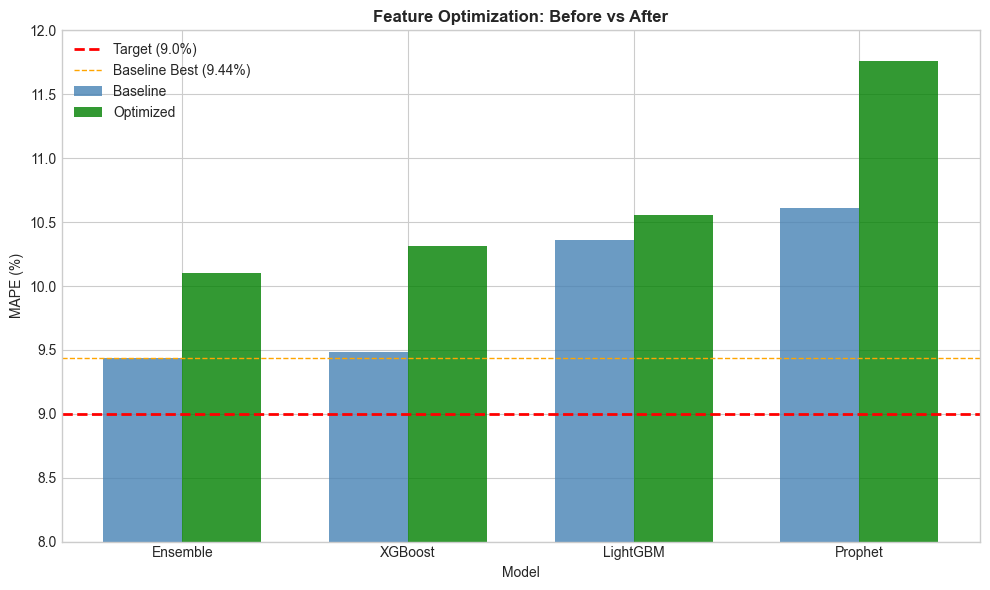

In [16]:
# Visualization: Before vs After
fig, ax = plt.subplots(figsize=(10, 6))

# Baseline results
baseline_models = ['Ensemble', 'XGBoost', 'LightGBM', 'Prophet']
baseline_mapes = [9.44, 9.48, 10.36, 10.61]

# Optimized results
opt_models = results_df['model_name'].tolist()
opt_mapes = results_df['mape_mean'].tolist()

x = np.arange(len(baseline_models))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_mapes, width, label='Baseline', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, opt_mapes[:len(baseline_models)], width, label='Optimized', color='green', alpha=0.8)

ax.axhline(y=9.0, color='red', linestyle='--', linewidth=2, label='Target (9.0%)')
ax.axhline(y=9.44, color='orange', linestyle='--', linewidth=1, label='Baseline Best (9.44%)')

ax.set_ylabel('MAPE (%)')
ax.set_xlabel('Model')
ax.set_title('Feature Optimization: Before vs After', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(baseline_models)
ax.legend()
ax.set_ylim(8, 12)

plt.tight_layout()
plt.show()